In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import json
from tqdm.auto import tqdm
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score
)

/Users/brenton/miniconda3/envs/EEG-SESM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sesm import get_data
from trainer import PLModel

In [3]:
config = json.load(open("configs/ecg.json", "r"))

In [4]:
train_loader, test_loader, class_weights, max_len = get_data(
    config["dataset"], config["batch_size"]
)
config.update({"class_weights": class_weights, "max_len": max_len})

In [5]:
plmodel = PLModel(stage=2, **config)
plmodel.model.load_state_dict(torch.load("models/trained_model.pt"))

<All keys matched successfully>

In [6]:
model = plmodel.model
model.eval()
model.training

False

# Accuracy

In [8]:
x_orig = []
y_pred = []
y_true = []
selective_actions_list = []
relevance_weights_list = []
predicted_head = []

for x, y in tqdm(test_loader):
    x, y = x, y
    batch_size = x.shape[0]
    y_hat_, _, selective_actions, relevance_weights = model(x, x != 0, ignore_relevance_weights=True) 
    
    y_hat_ = y_hat_.detach().reshape(batch_size, config['n_heads'], -1).cpu()
    selective_actions = selective_actions.detach().cpu()
    relevance_weights = relevance_weights.detach().cpu() 
    x = x.detach().cpu()
    y = y.detach().cpu()

    y_hat = (y_hat_ * relevance_weights.unsqueeze(-1)).sum(1)

    x_orig.append(np.concatenate(x.numpy()))
    y_pred.append(y_hat.argmax(1).numpy())
    y_true.append(y.numpy())
    selective_actions_list.append(selective_actions.numpy())
    relevance_weights_list.append(relevance_weights.numpy())
    predicted_head.append(F.softmax(y_hat_, -1).numpy())
    del x, y, y_hat, _, selective_actions, relevance_weights
    
x_orig = np.concatenate(x_orig)
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
selective_actions = np.concatenate(selective_actions_list)
relevance_weights = np.concatenate(relevance_weights_list)
predicted_head = np.concatenate(predicted_head)

  0%|          | 0/55 [00:00<?, ?it/s]/Users/brenton/miniconda3/envs/EEG-SESM/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1659484612588/work/aten/src/ATen/native/Convolution.cpp:883.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 55/55 [13:24<00:00, 14.63s/it]


In [9]:
(
    accuracy_score(y_true, y_pred),
    precision_score(y_true, y_pred, average="macro"),
    recall_score(y_true, y_pred, average="macro"),
)

(0.9773890005481455, 0.9119978591977164, 0.8338440738572193)

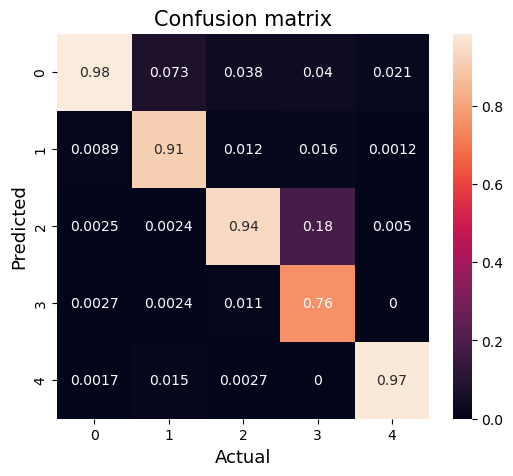

In [10]:
C = confusion_matrix(y_true, y_pred)
C = C / C.astype(float).sum(axis=0)

fig, ax = plt.subplots(figsize=(6, 5))
# cm_ = ax.imshow(C, cmap="hot")
sns.heatmap(C, annot=True)
ax.set_title("Confusion matrix", fontsize=15)
ax.set_xlabel("Actual", fontsize=13)
ax.set_ylabel("Predicted", fontsize=13)
# plt.colorbar(cm_)
plt.show()

# Attention Visualisation

In [11]:
selection = np.zeros((selective_actions.shape[0], selective_actions.shape[1], max_len))
for i in tqdm(range(selective_actions.shape[0])):
    for h in range(selective_actions.shape[1]):
        for k in range(selective_actions.shape[-1]):
            if selective_actions[i, h, k] > 0:
                left = max(0, k - 5)
                right = min(max_len, k + 5)
                selection[i, h, left:right] = 1

selection.shape

100%|██████████| 21892/21892 [00:35<00:00, 622.53it/s]


(21892, 8, 187)

In [12]:
test = np.nonzero(selection[111,2])[0]
test_diff = np.diff(test, append=0)
test.shape, test_diff.shape
print(test_diff)
test_mask = test_diff <= 2
print(test_mask)
print(test[test_mask])

[   1    1    1    1    1   18    1    1    1    1    1    1    1    1
    1    1    1    1    1    1   53    1    1    1    1    1    1    1
    1    1    1    1    1    1 -103]
[ True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]
[  0   1   2   3   4  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  90  91  92  93  94  95  96  97  98  99 100 101 102 103]


In [13]:
" ".join([str(i) for i in np.where((y_true == 4) & (y_pred == 4))[0]][:100])

'20284 20285 20286 20287 20288 20289 20290 20291 20292 20293 20294 20295 20296 20297 20298 20299 20300 20301 20302 20303 20304 20305 20306 20307 20308 20309 20310 20311 20312 20313 20314 20315 20316 20317 20318 20319 20320 20321 20322 20323 20325 20326 20327 20328 20329 20330 20331 20332 20333 20334 20335 20336 20338 20339 20340 20341 20342 20343 20344 20345 20346 20347 20348 20349 20350 20352 20353 20355 20356 20357 20358 20359 20360 20361 20363 20364 20365 20366 20367 20368 20369 20370 20371 20372 20373 20374 20375 20376 20377 20379 20380 20381 20382 20384 20385 20386 20387 20388 20389 20390'

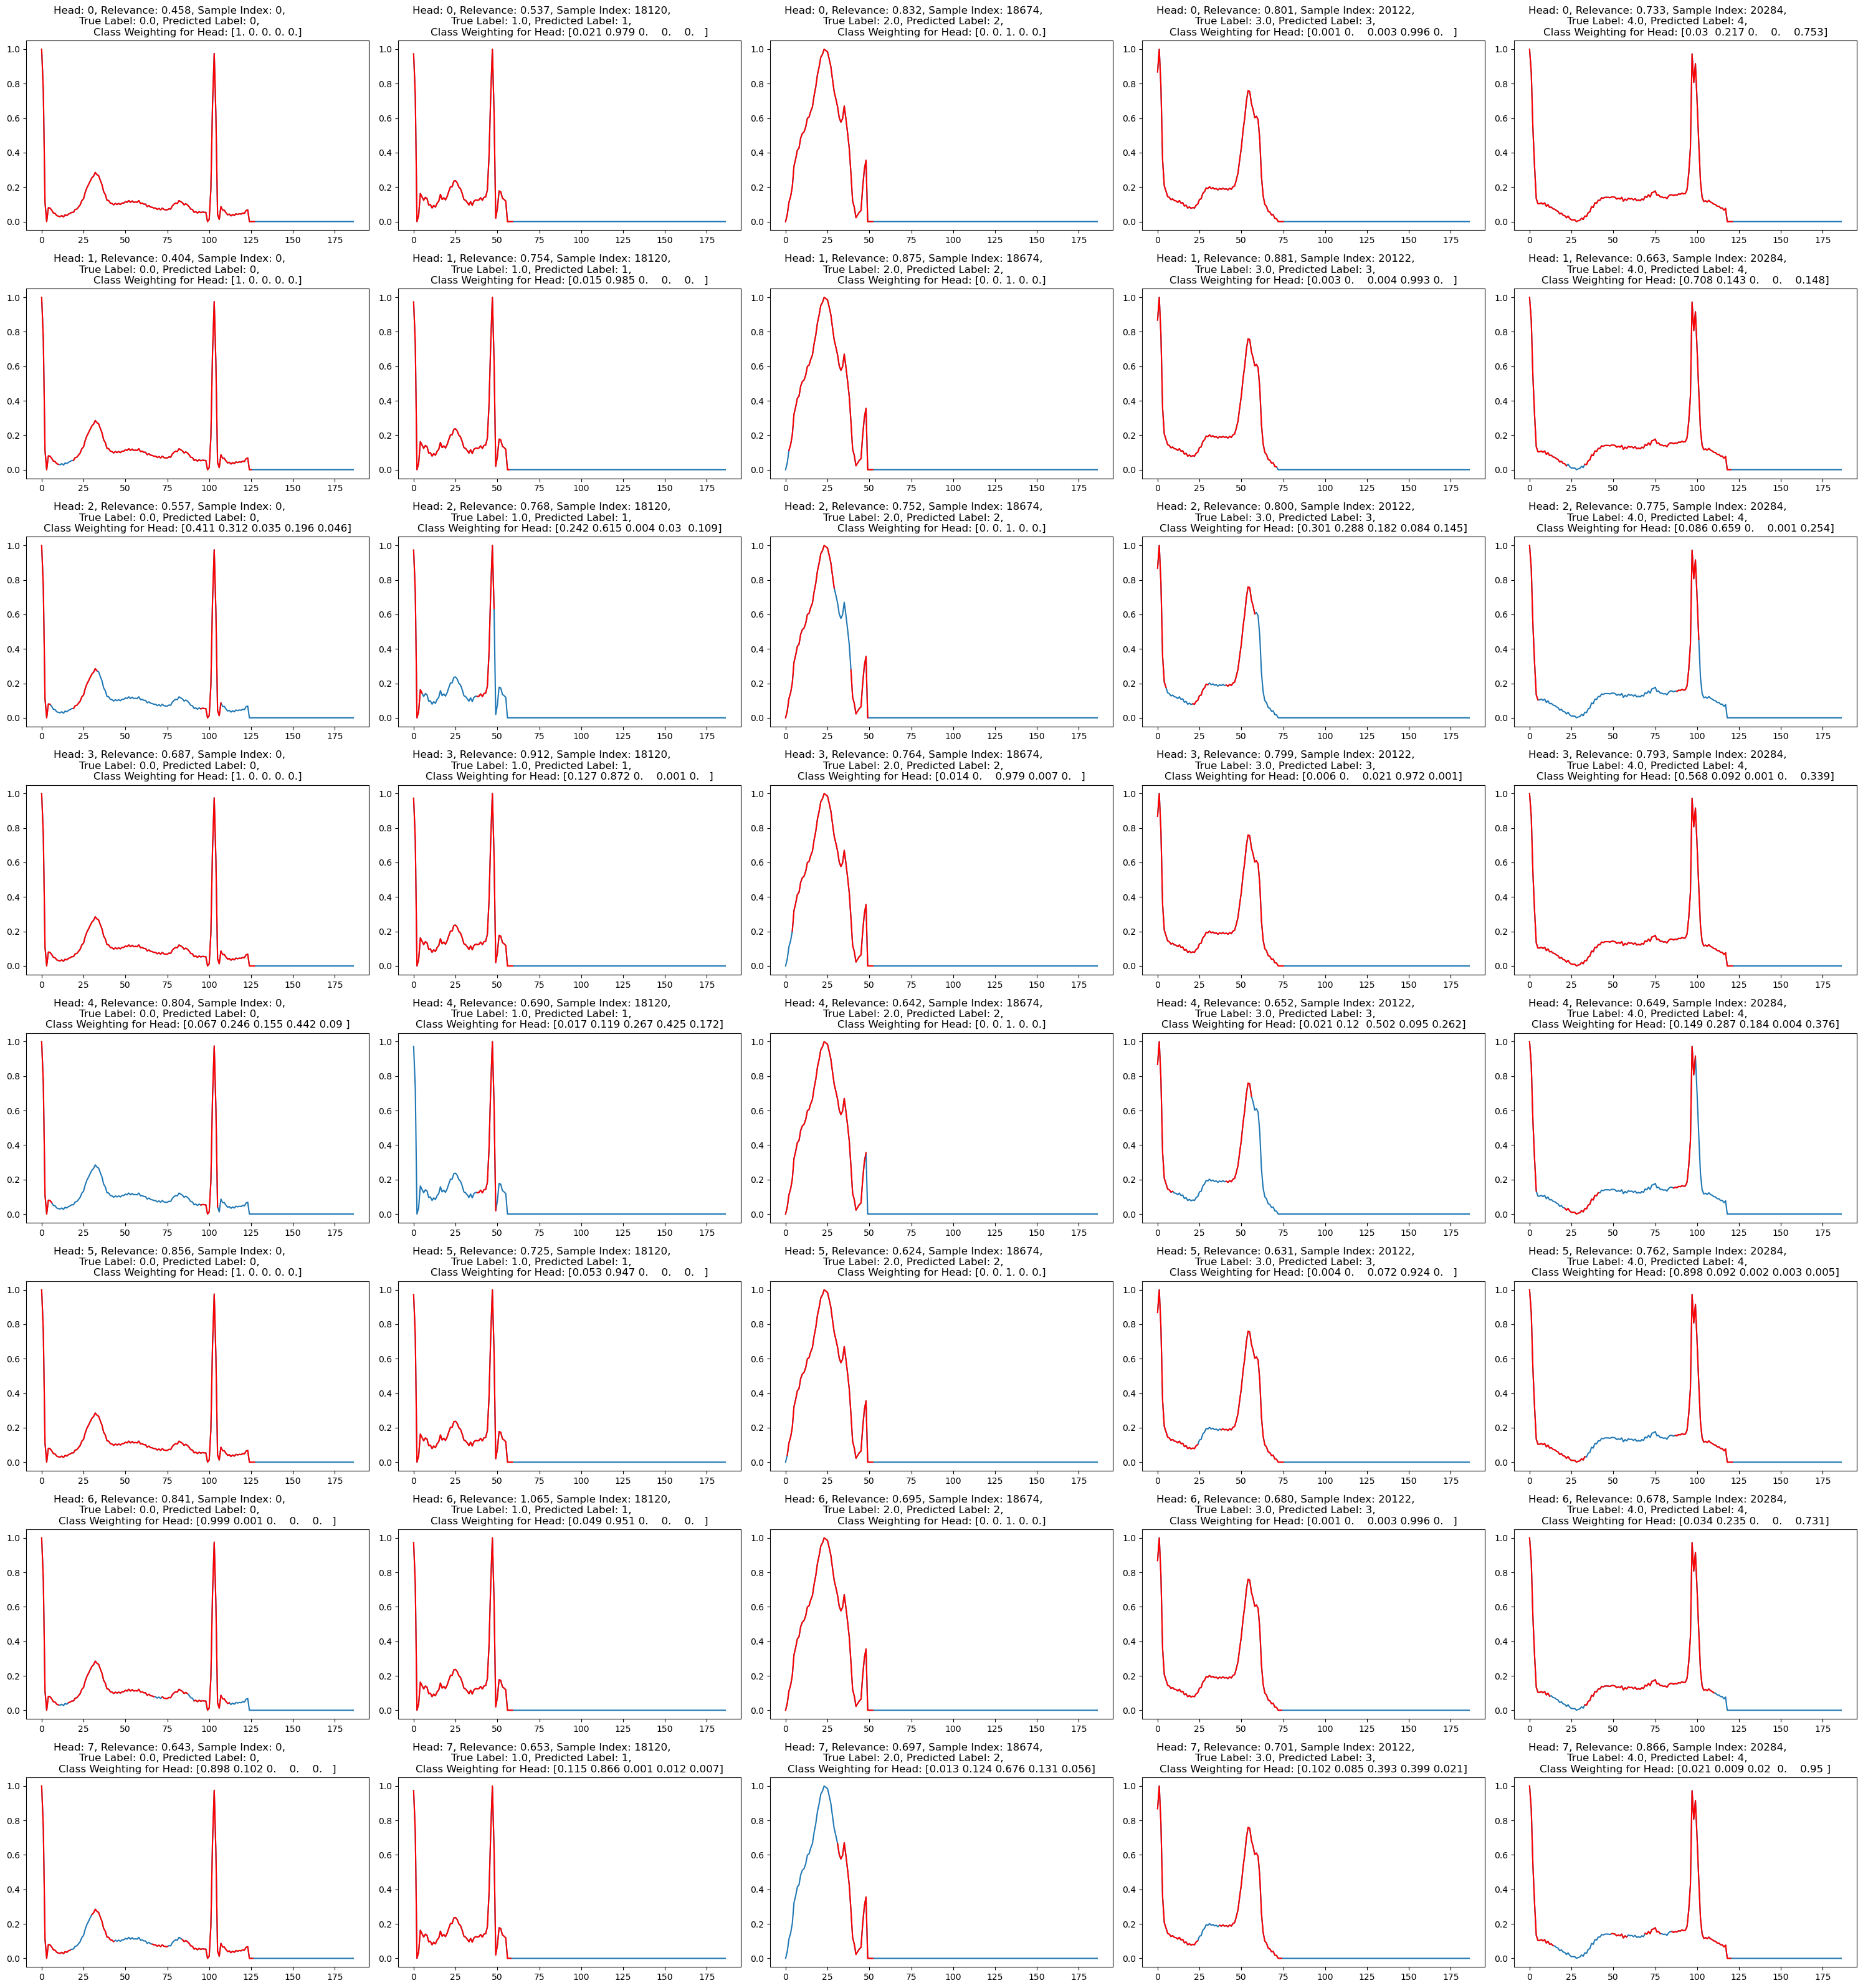

In [15]:
# indices = np.array([[24, 25], [28, 214], [27, 13883], [14552, 6043], [17, 31]]).flatten("F")
indices = np.array([0, 18120, 18674, 20122, 20284])
# indices = (np.where(y_true == 2) and np.where(y_pred == 2))[0][1:6]

n = len(indices)
fig, ax = plt.subplots(8, 5, figsize=(30, 32))
# ax = axes.flatten()


for i in range(n):
    idx = indices[i]
    # print(y_true[idx], y_pred[idx])
    # print(relevance_weights[idx].tolist())

    for head in range(8):

        # print(selection[idx].sum(-1))
        # head = selection[idx].sum(-1).argmax()

        #sns.lineplot(x=np.arange(max_len), y=x_orig[idx], ax=ax[head, i])

        # print((x_orig[idx] * selection[idx, head]).sum())

        nonzero = np.nonzero(selection[idx, head])[0]

        # Create a connect mask
        nonzero_diff = np.diff(nonzero, append=0)
        threshold = 2
        connect_mask = nonzero_diff <= threshold
        split_indices = np.where(~connect_mask)[0]
        components = np.split(nonzero, split_indices + 1)

        #sns.pointplot(x=nonzero, y=x_orig[idx, nonzero], ax=ax[head, i], hue=connect_mask, legend=False, markers='')
        
        ax[head, i].plot(np.arange(max_len), x_orig[idx])
        # Overlay non-connected line segments
        for component in components:
            ax[head, i].plot(component, x_orig[idx, component], color='r')

        # ax[head, i].title.set_text(
        #     f"{h}, {idx}, {relevance_weights[idx, head]}, {y_true[idx]}, {y_pred[idx]}"
        # )
        ax[head, i].title.set_text(
            f"Head: {head}, Relevance: {relevance_weights[idx][head]:0.3f}, Sample Index: {idx}, \
                \nTrue Label: {y_true[idx]}, Predicted Label: {y_pred[idx]}, \
                \nClass Weighting for Head: {np.around(predicted_head[idx, head], 3)}"
        )


plt.tight_layout()
plt.show()